In [16]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

In [4]:
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

In [5]:
spectra_filtered = spectra[mask]
images_filtered = images[mask]
metadata_indices_filtered = metadata_indices[mask]

In [6]:
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]
redshifts = valid_sfrs.loc[metadata_indices_filtered, "Z"].values

In [7]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

In [8]:
labels_simplified = pd.Series(labels).apply(simplify_targettype).values

nan_mask = ~np.isnan(spectra_filtered).any(axis=1)
spectra_filtered = spectra_filtered[nan_mask]
images_filtered = images_filtered[nan_mask]
labels_simplified = labels_simplified[nan_mask]
redshifts = redshifts[nan_mask]

In [9]:
filters = ["u", "g", "r", "i", "z"]
all_images = []
all_spectra = []
reference_spectrum = None
valid_indices = None

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"

    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
    
    if zoom == 0:
        valid_indices = ~np.isnan(spectra_zoom).any(axis=1)
        reference_spectrum = spectra_zoom[valid_indices].copy()
        reference_images = images_zoom[valid_indices].copy()
    
    images_zoom = images_zoom[valid_indices]
    spectra_zoom = spectra_zoom[valid_indices]
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)  
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

In [38]:
def detect_and_visualize_multiple_objects(all_images, thresholds, max_objects=20, thumbnail_size=3, crop_sizes=None):
    all_images_trimmed = []
    for i, img_array in enumerate(all_images):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size)
        
        start = (original_size - target_size) // 2
        end = start + target_size
        
        trimmed = img_array[..., start:end, start:end]
        all_images_trimmed.append(trimmed)
    
    multi_obj_indices = []
    for idx in range(all_images_trimmed[0].shape[0]):
        image = all_images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds[0]
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)

    if len(multi_obj_indices) > max_objects:
        print(f"Found {len(multi_obj_indices)} objects. Showing first {max_objects}")
        multi_obj_indices = multi_obj_indices[:max_objects]

    if not multi_obj_indices:
        print("No multi-object sources found")
        return all_images_trimmed
    
    num_rows = len(multi_obj_indices)
    fig, axes = plt.subplots(
        num_rows,
        5,
        figsize=(15, thumbnail_size * num_rows),
        dpi=100
    )
    
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for row, obj_idx in enumerate(multi_obj_indices):
        for col in range(5):
            ax = axes[row, col]
            img_data = all_images_trimmed[0][obj_idx, col, :, :]
            ax.imshow(img_data, vmin=-1, vmax=1)
            ax.set_title(f"Filter {filters[col]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    return all_images_trimmed

## No crop:

In [55]:
CROP_SIZES_NO = {
    0: 64,
    1: 32,  
    2: 16,  
    3: 8   
}

THRESHOLDS_NO = {
    0: 0.3,
    1: 0.35,
    2: 0.4,
    3: 0.45
}

Found 4268 objects. Showing first 10


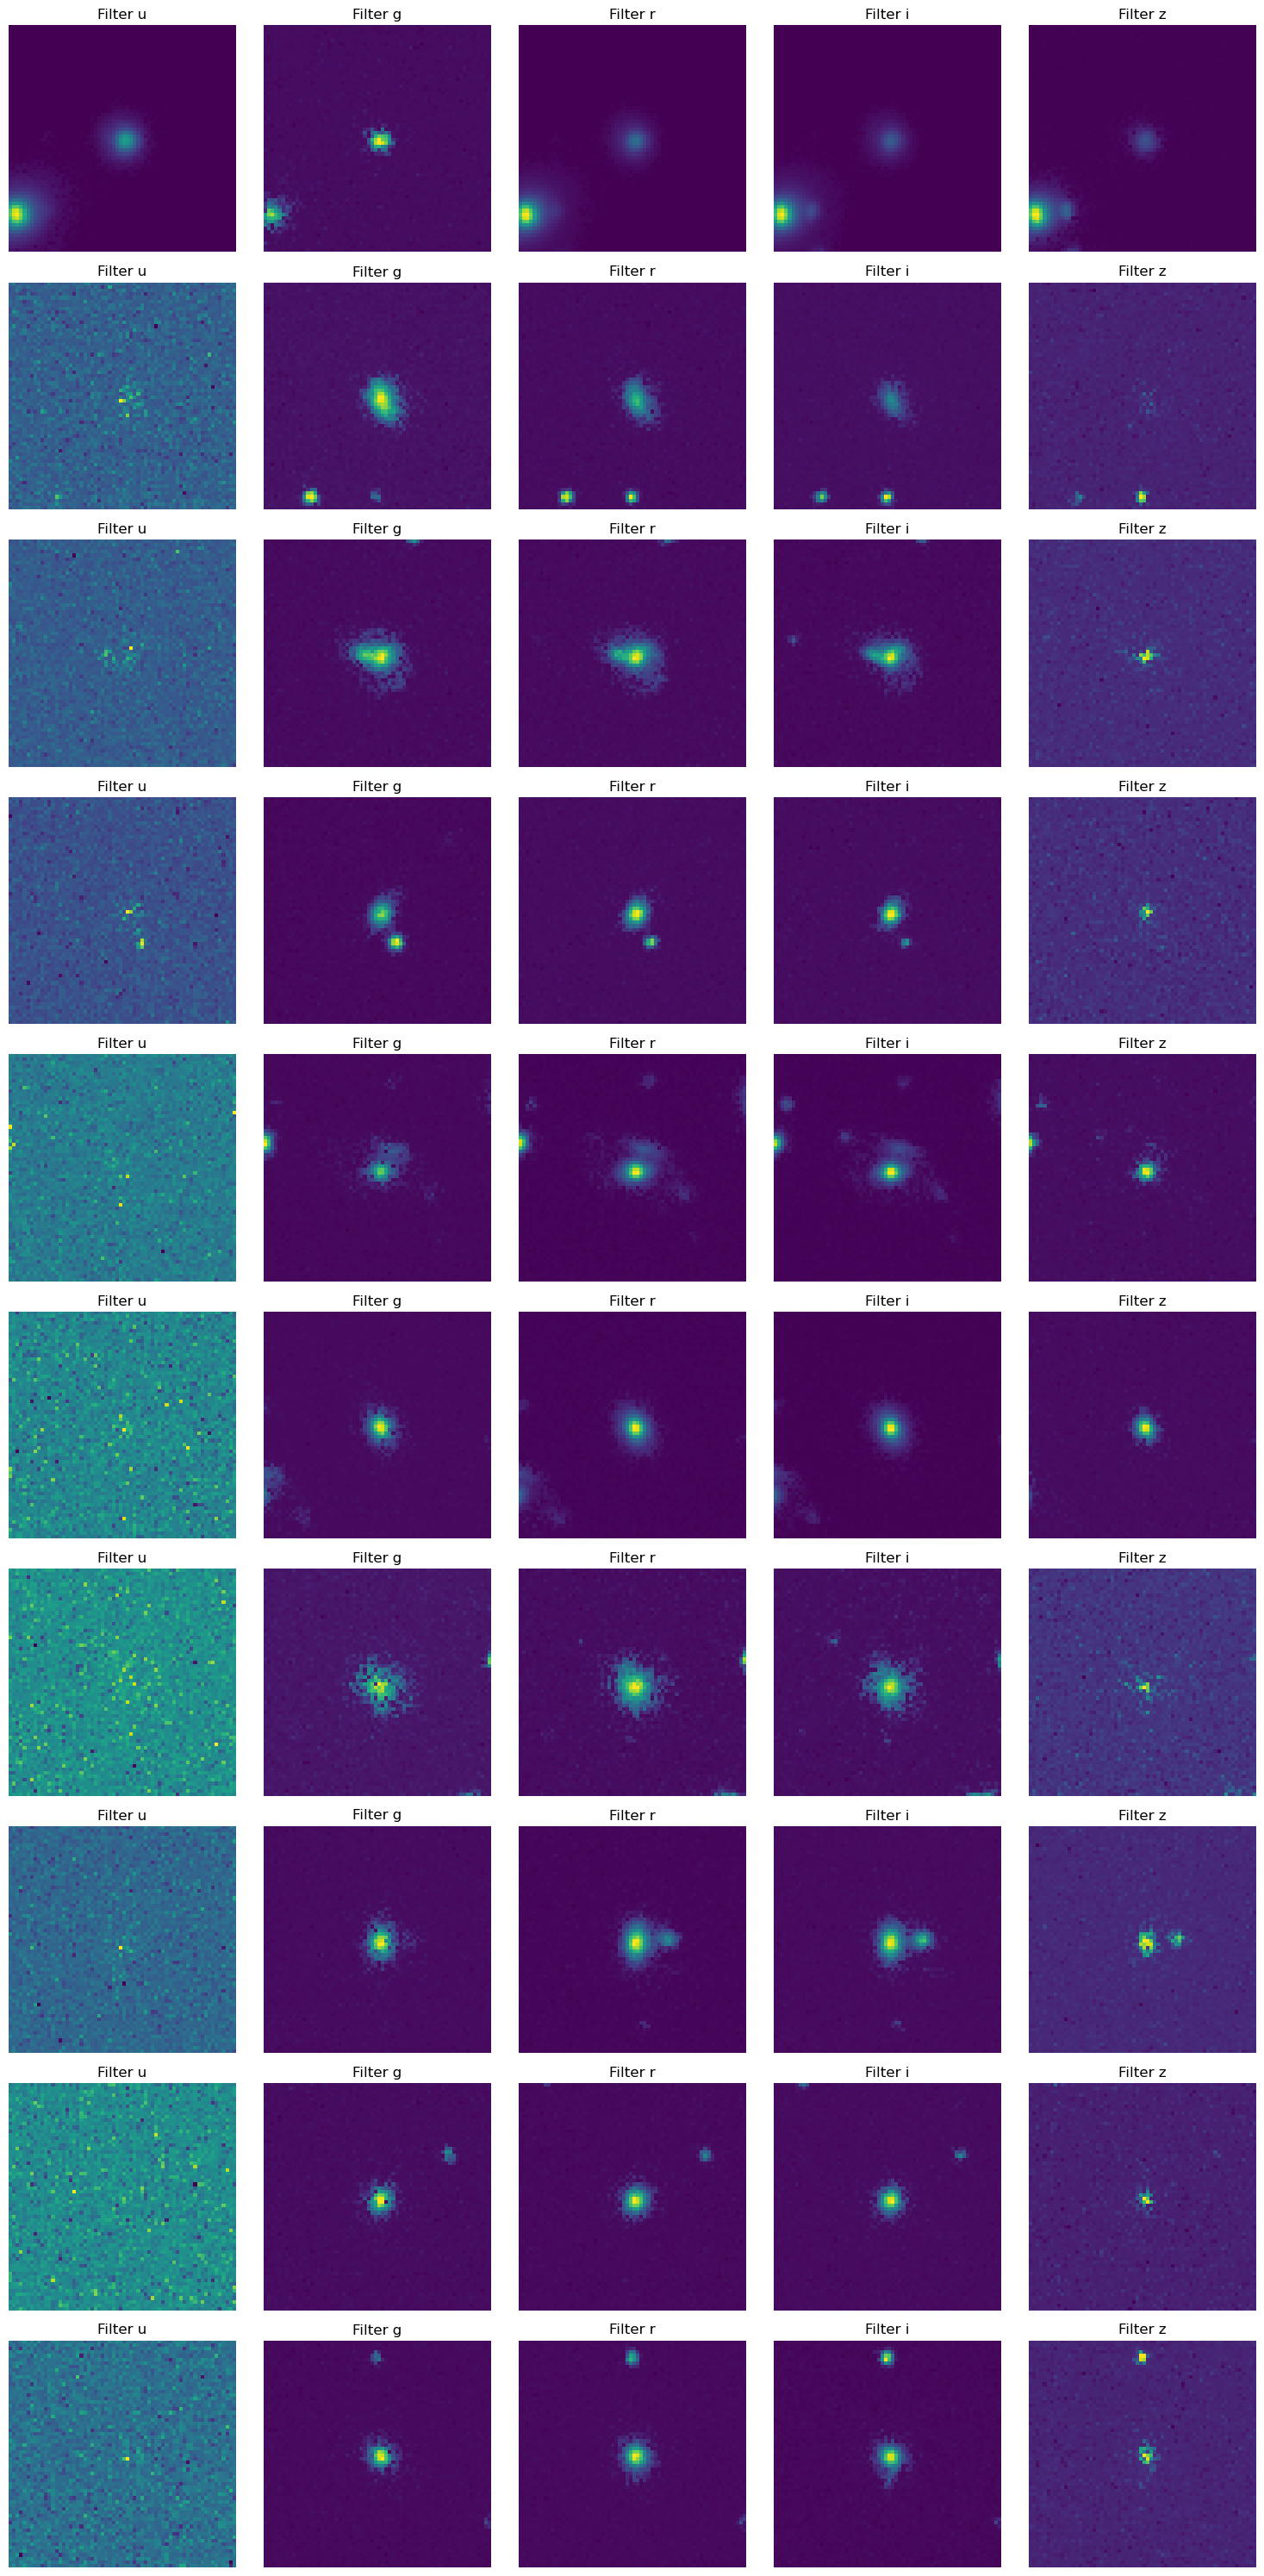

In [56]:
trimmed_images = detect_and_visualize_multiple_objects(
    all_images,
    thresholds=THRESHOLDS_NO,
    max_objects=10,
    thumbnail_size=3,
    crop_sizes=CROP_SIZES_NO
)

## 25% crop:

Found 2994 objects. Showing first 10


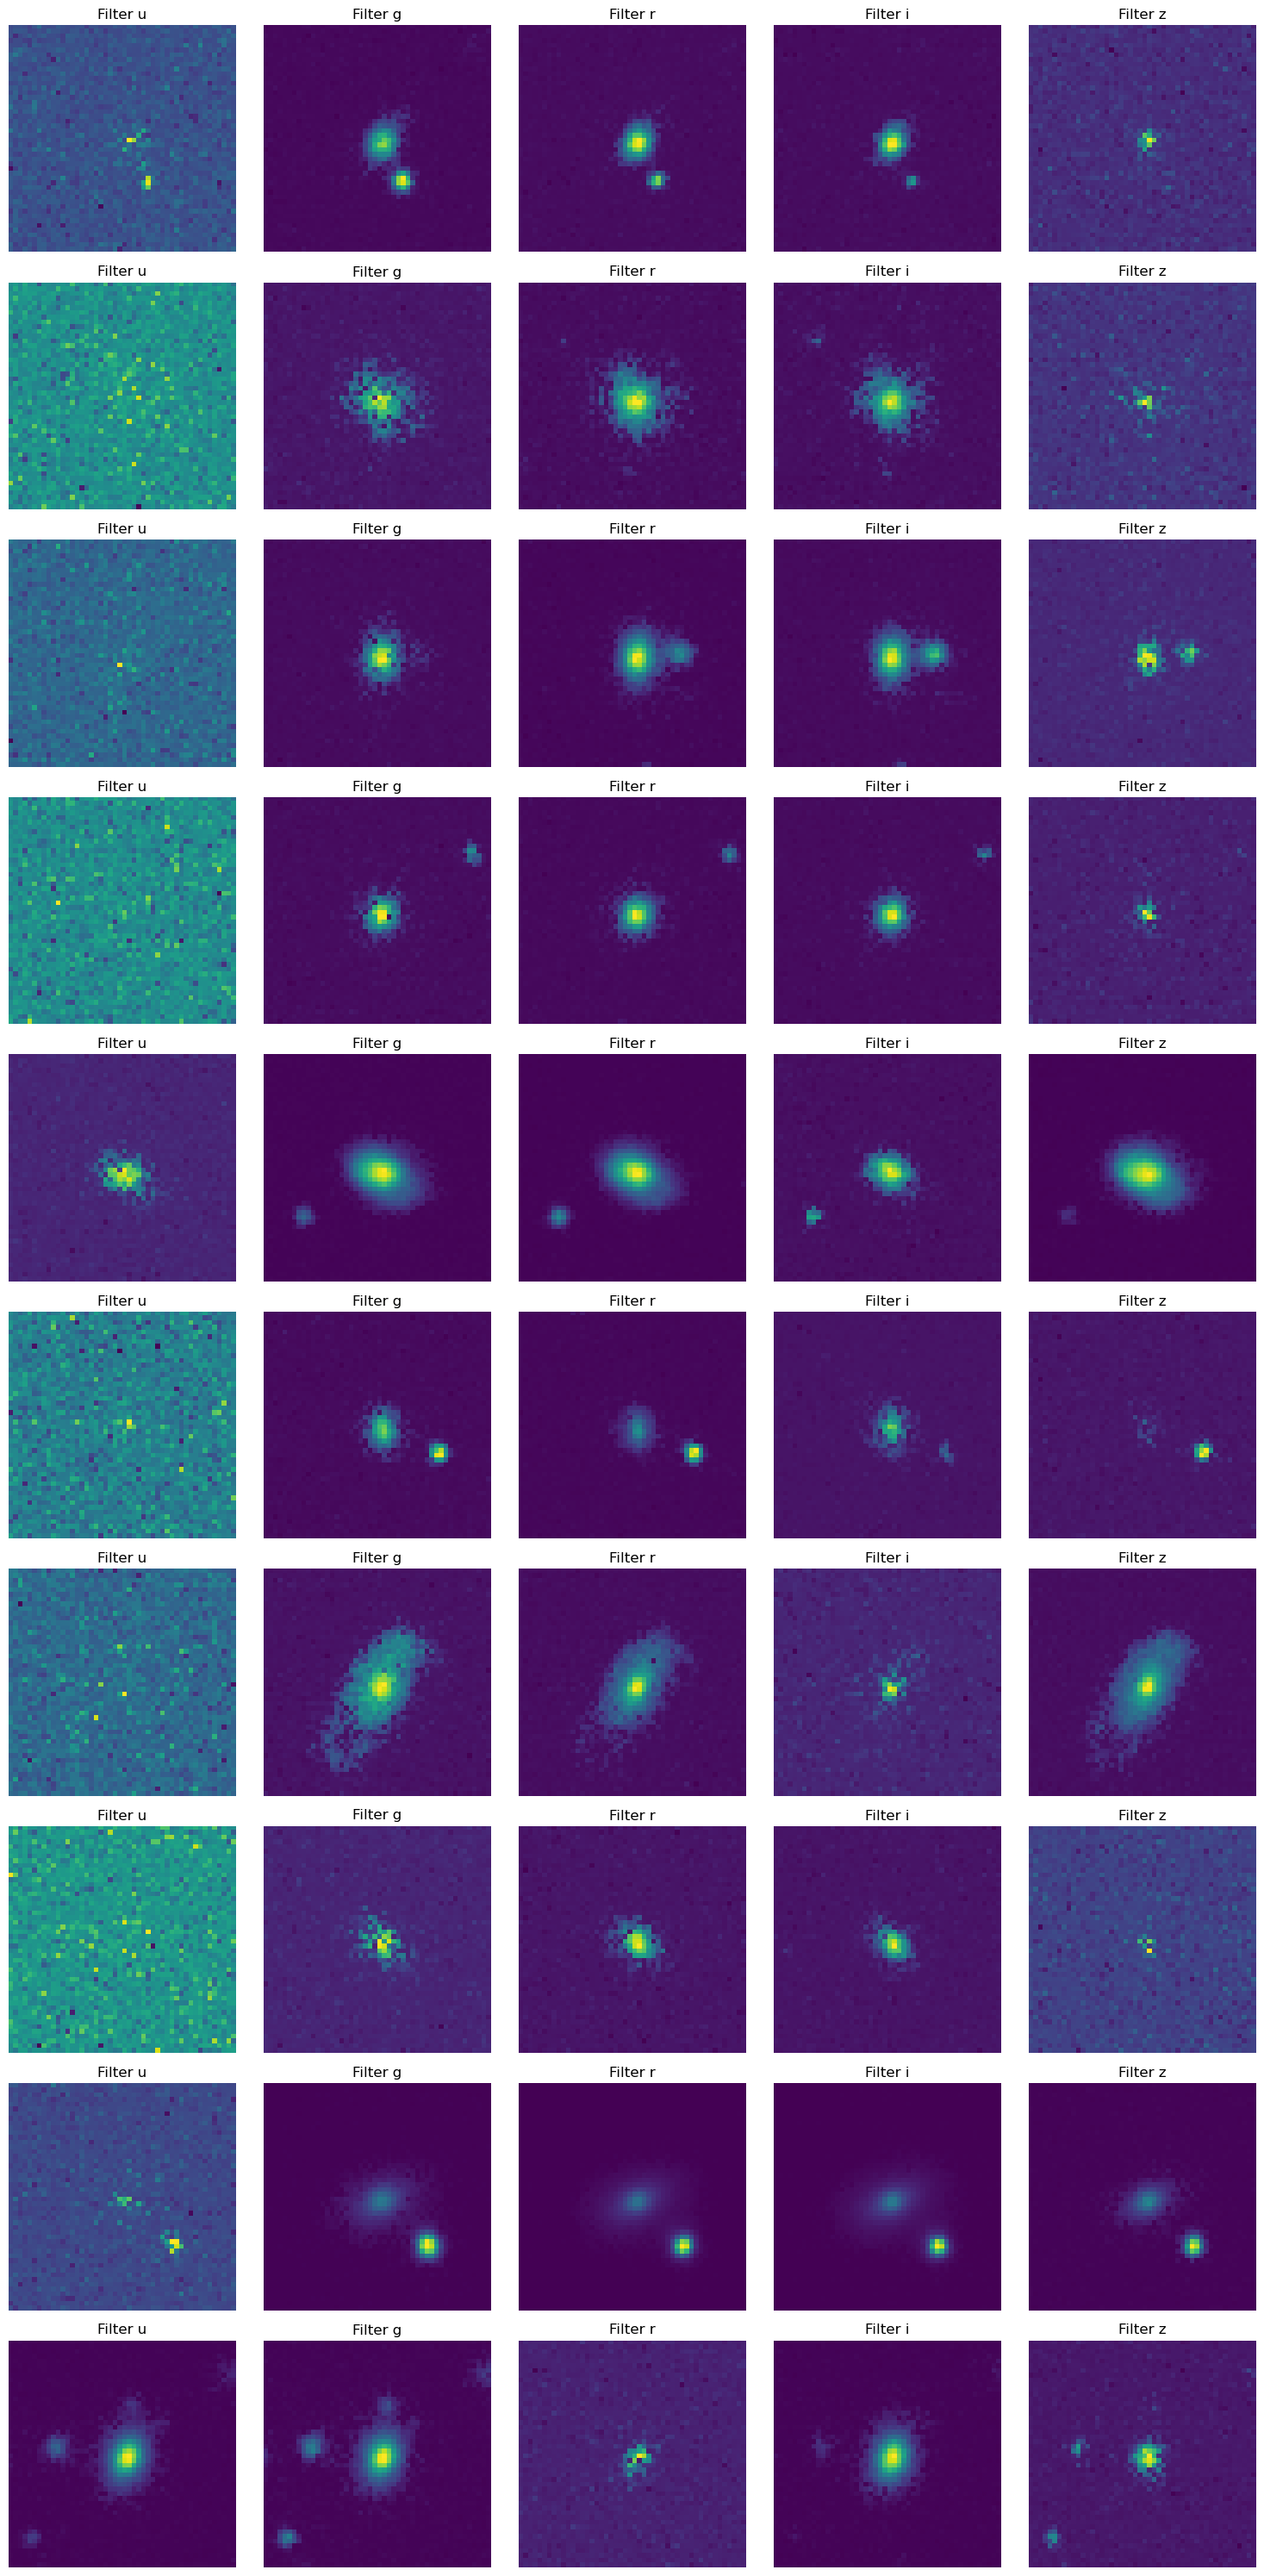

In [63]:
THRESHOLDS_6 = {
    0: 0.35,
    1: 0.4,
    2: 0.45,
    3: 0.5
}

CROP_SIZES_6 = {
    0: 48,  # 64x64 -> 48x48
    1: 24,  # 32x32 -> 24x24
    2: 12,  # 16x16 -> 12x12
    3: 6    # 8x8 -> 6x6
}


trimmed_images = detect_and_visualize_multiple_objects(
    all_images,
    thresholds=THRESHOLDS_6,
    max_objects=10,
    thumbnail_size=3,
    crop_sizes=CROP_SIZES_6
)

## 50% crop:

Found 2151 objects. Showing first 10


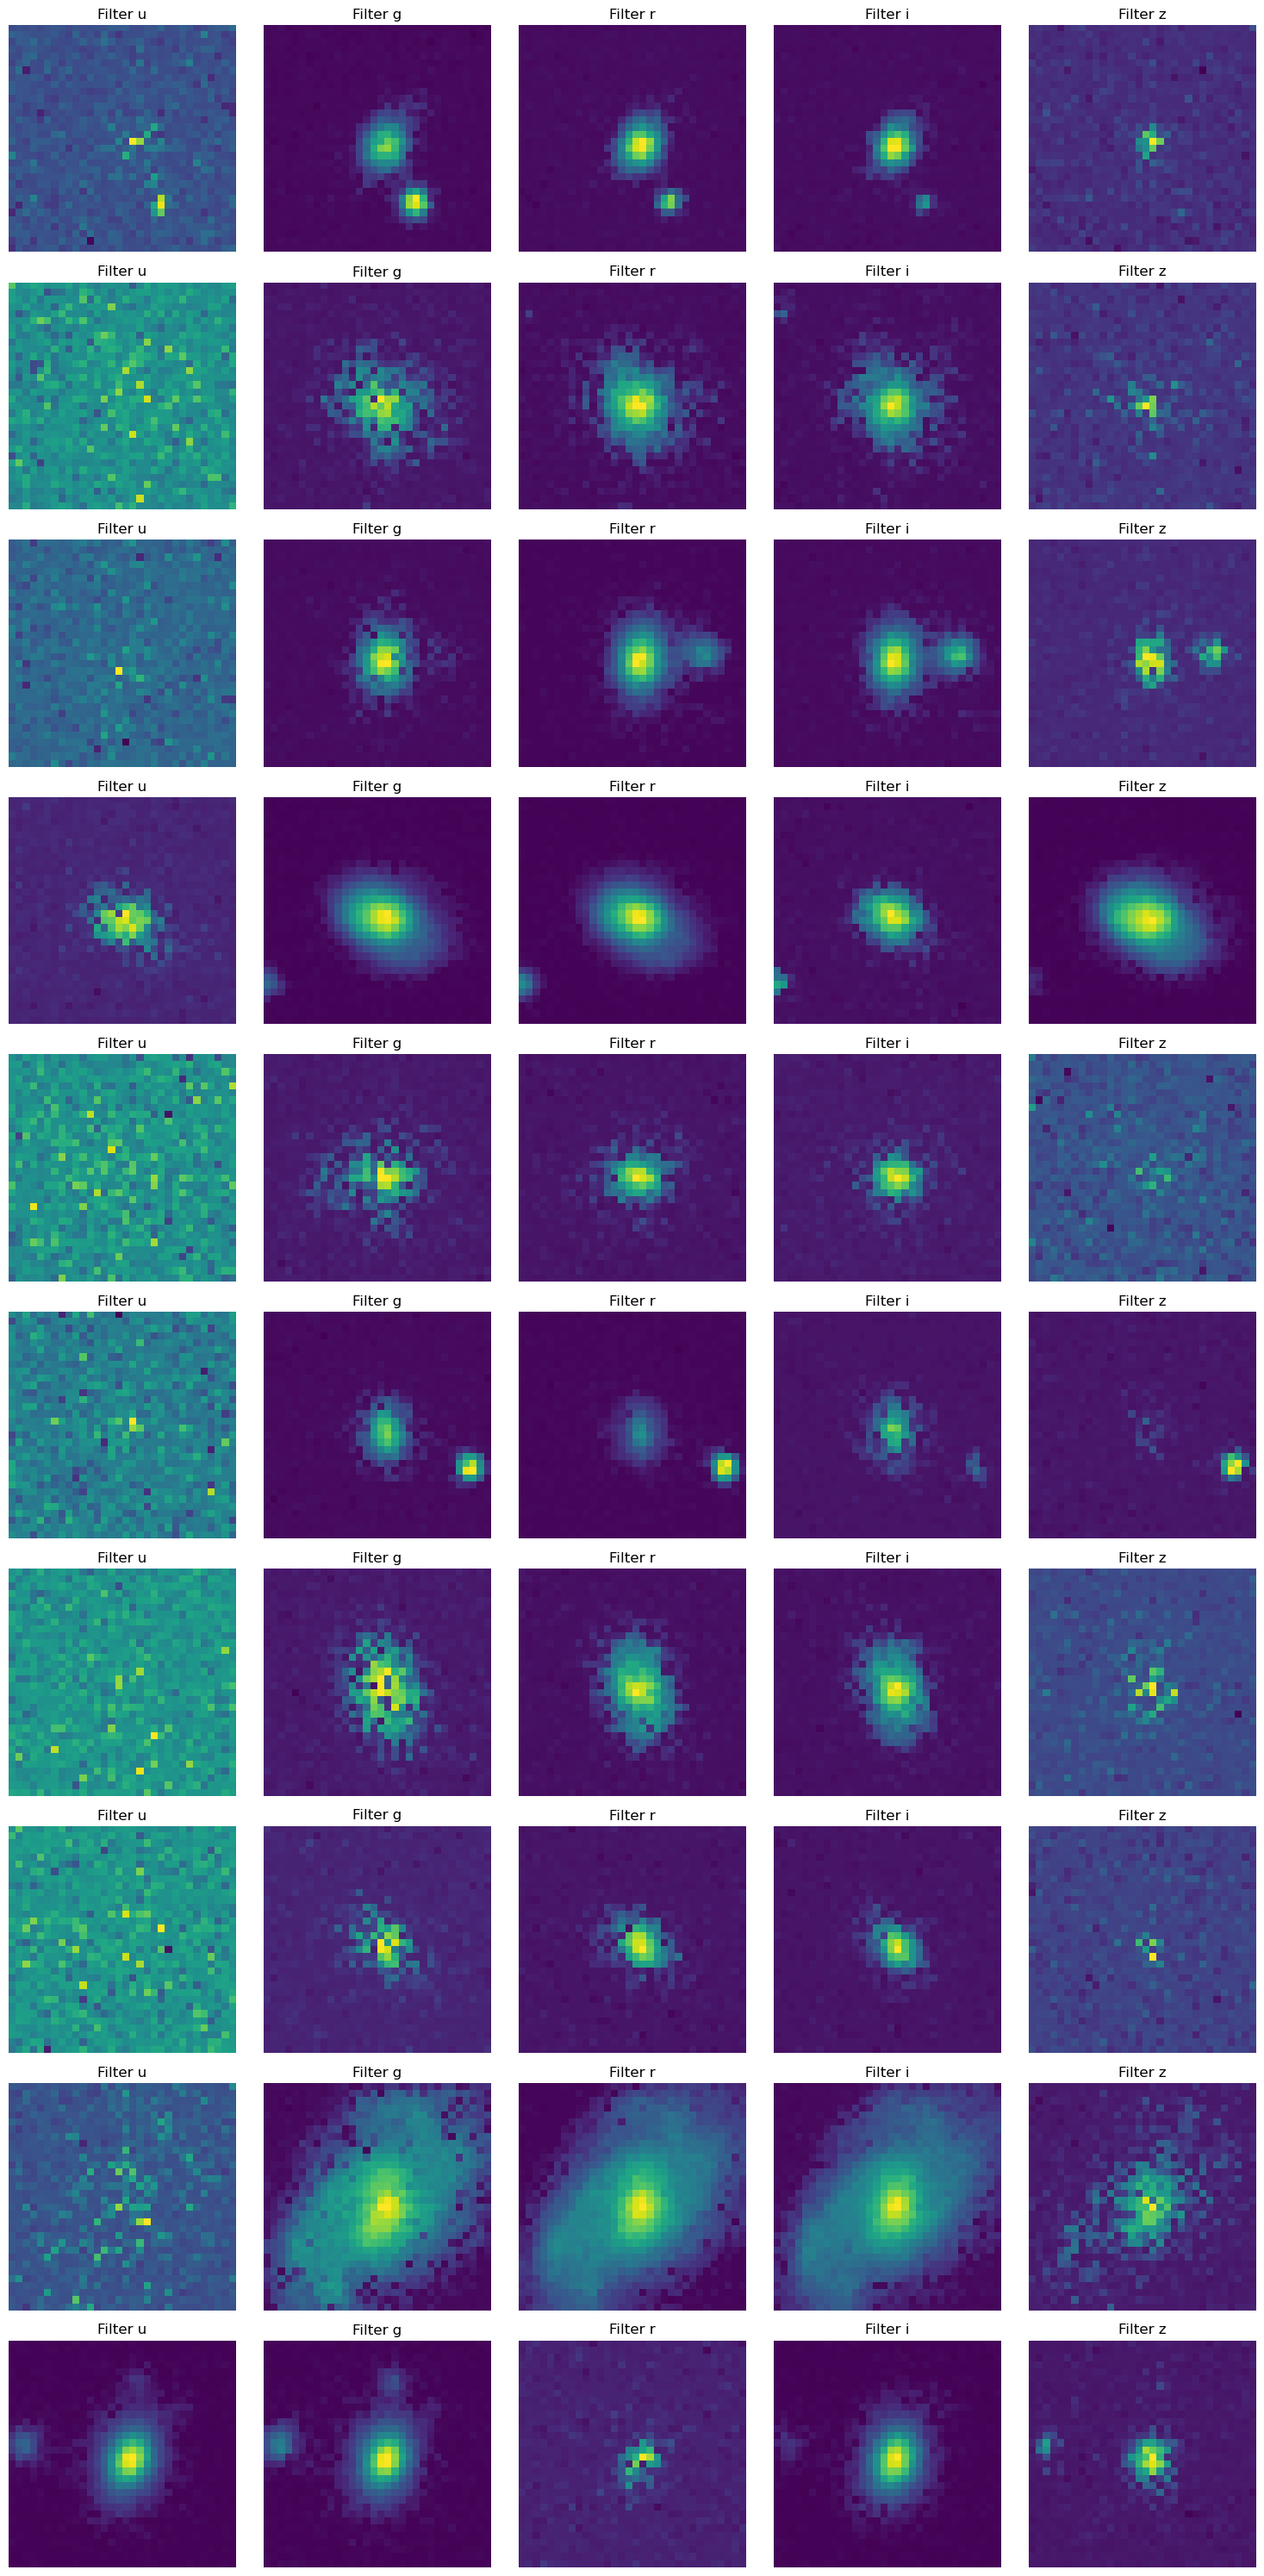

In [64]:
THRESHOLDS = {
    0: 0.4,
    1: 0.45,
    2: 0.5,
    3: 0.55
}

CROP_SIZES_4 = {
    0: 32,  # 64x64 -> 32x32
    1: 16,  # 32x32 -> 16x16
    2: 8,  # 16x16 -> 8x8
    3: 4    # 8x8 -> 4x4
}


trimmed_images = detect_and_visualize_multiple_objects(
    all_images,
    thresholds=THRESHOLDS,
    max_objects=10,
    thumbnail_size=3,
    crop_sizes=CROP_SIZES_4
)

## 75% crop:

Found 319 objects. Showing first 10


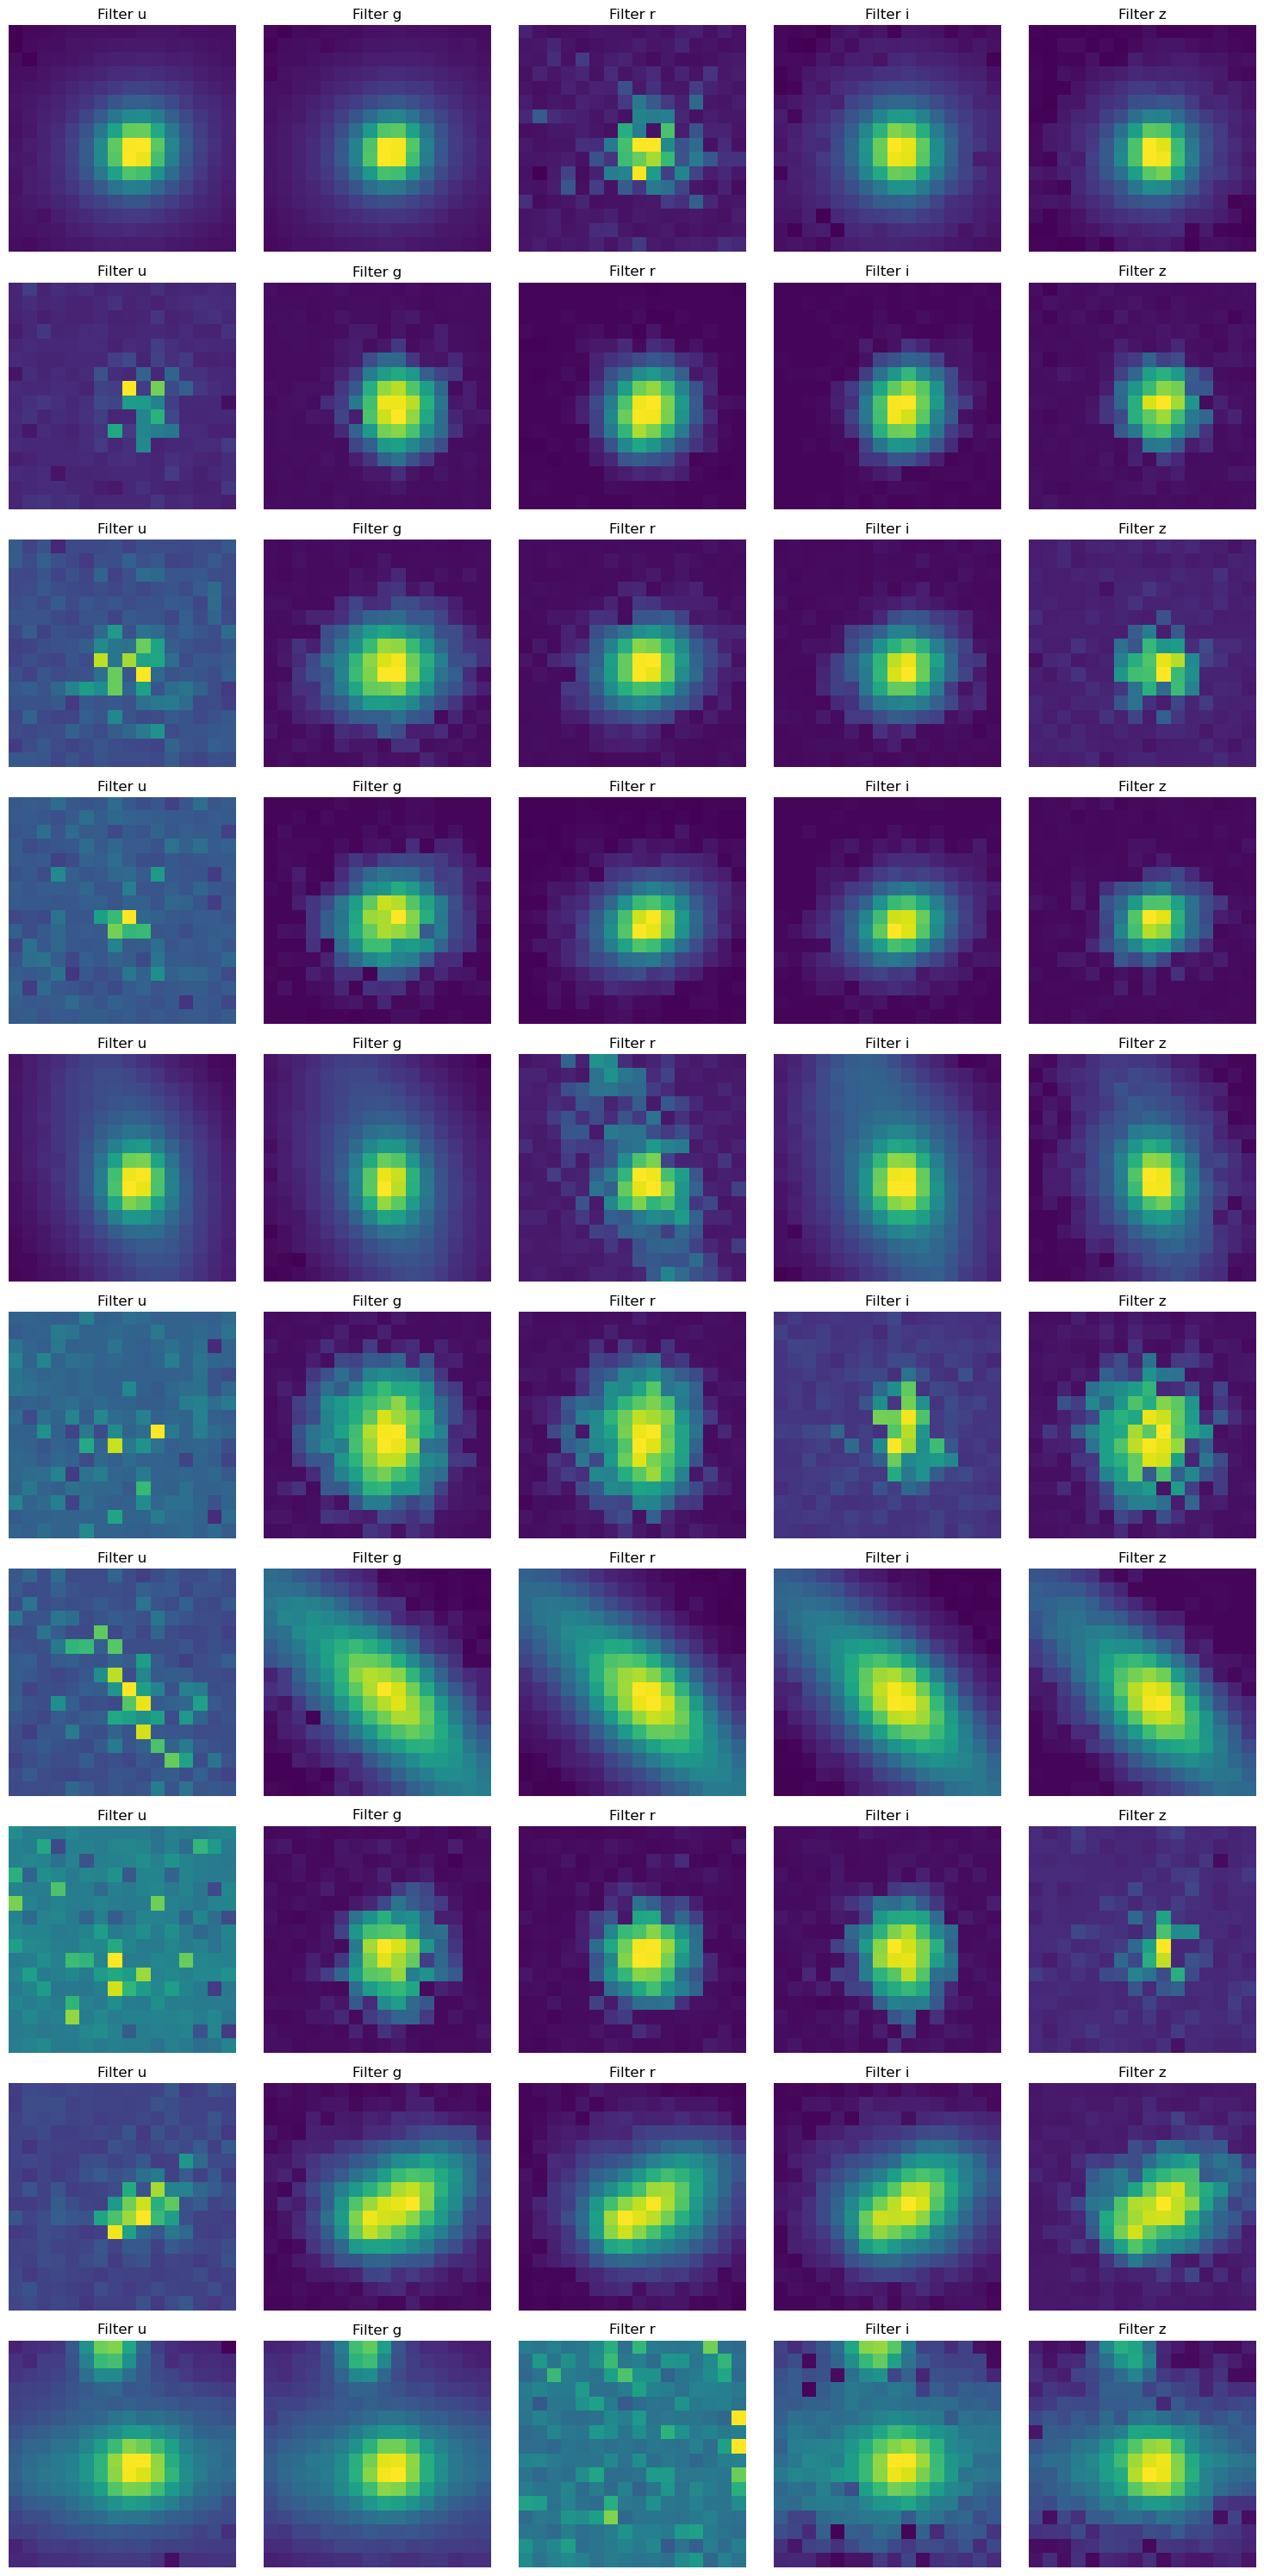

In [72]:
THRESHOLDS_2 = {
    0: 0.99,
    1: 0.8,
    2: 0.85,
    3: 0.9
}

CROP_SIZES_2 = {
    0: 16, 
    1: 8, 
    2: 4, 
    3: 2   
}


trimmed_images = detect_and_visualize_multiple_objects(
    all_images,
    thresholds=THRESHOLDS_2,
    max_objects=10,
    thumbnail_size=3,
    crop_sizes=CROP_SIZES_2
)